### Course Name and Number: DSC 540 Advanced Machine Learning - SEC 701
### Student Name: Mai Ngo
### Final Project: Astronomical Time Series Data Classification
### Date: 3/18/2024

In [1]:
#Mount my Google Drive
from google.colab import drive
drive.mount("/content/drive")
import os
directory = '/content/drive/My Drive/DSC540 Final Project'
os.chdir(directory)

#Ensure the files are there (in the folder)
!pwd

Mounted at /content/drive
/content/drive/My Drive/DSC540 Final Project


In [3]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.3 MB/s eta 0:00:00


In [4]:
#For data preprocessing.
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from IPython.display import display

#For Random Forest Classifier.
import time
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, log_loss, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.feature_selection import SelectFromModel

#For Gradient Boosting Classifier.
from sklearn.ensemble import GradientBoostingClassifier

#For SVM Classifier.
from sklearn.svm import SVC

#For Ada Boost Classifier.
from sklearn.ensemble import AdaBoostClassifier

#For Neural Network.
from tensorflow import keras
from keras.models import Model
from keras.layers import Input, LSTM, Dense, Activation, Concatenate, Flatten, Dropout
from keras import optimizers
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from kerastuner.tuners import RandomSearch

#For data imbalance.
from sklearn.utils import resample

#For plotting.
from collections import Counter
from operator import itemgetter
import matplotlib.pyplot as plt
import seaborn as sns

#For warnings ignore.
import warnings
warnings.filterwarnings("ignore")

<ipython-input-4-0eb112da2dd0>:30: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## **Read dataset as pandas data frame.**
### Meta data is typical STATIC numerical data.

In [5]:
metaData = pd.read_csv('training_set_metadata.csv', encoding = 'utf-8')
print(f'Meta Data: Row - {metaData.shape[0]} | Column - {metaData.shape[1]}')
print(f"Meta Data: Number of Object ID: {metaData['object_id'].nunique()} | Number of Target Classes: {metaData['target'].nunique()}")

Meta Data: Row - 7848 | Column - 12
Meta Data: Number of Object ID: 7848 | Number of Target Classes: 14


In [6]:
metaData.head(3)

object_id          ra       decl       gal_l      gal_b  ddf  \
0        615  349.046051 -61.943836  320.796530 -51.753706    1   
1        713   53.085938 -27.784405  223.525509 -54.460748    1   
2        730   33.574219  -6.579593  170.455585 -61.548219    1   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  distmod  mwebv  target  
0         0.0000          0.0000              0.0000      NaN  0.017      92  
1         1.8181          1.6267              0.2552  45.4063  0.007      88  
2         0.2320          0.2262              0.0157  40.2561  0.021      42

### Missing values. Only 'distmod': 30% missing data --> Decided to drop.

In [7]:
missingValues_count =metaData.isnull().sum()
naColumns = missingValues_count[missingValues_count > 0]
print("Columns with Missing Values:")
print(naColumns)

Columns with Missing Values:
distmod    2325
dtype: int64


In [8]:
#Also drop 'ddf' - deep drilling field observered object. --> More align with research objective. Will explain in the report.
metaData = metaData.drop(columns=['distmod', 'ddf'])
metaData.head(5)

object_id          ra       decl       gal_l      gal_b  hostgal_specz  \
0        615  349.046051 -61.943836  320.796530 -51.753706         0.0000   
1        713   53.085938 -27.784405  223.525509 -54.460748         1.8181   
2        730   33.574219  -6.579593  170.455585 -61.548219         0.2320   
3        745    0.189873 -45.586655  328.254458 -68.969298         0.3037   
4       1124  352.711273 -63.823658  316.922299 -51.059403         0.1934   

   hostgal_photoz  hostgal_photoz_err  mwebv  target  
0          0.0000              0.0000  0.017      92  
1          1.6267              0.2552  0.007      88  
2          0.2262              0.0157  0.021      42  
3          0.2813              1.1523  0.007      90  
4          0.2415              0.0176  0.024      90

### **EDA on static data.**
### Location Data.

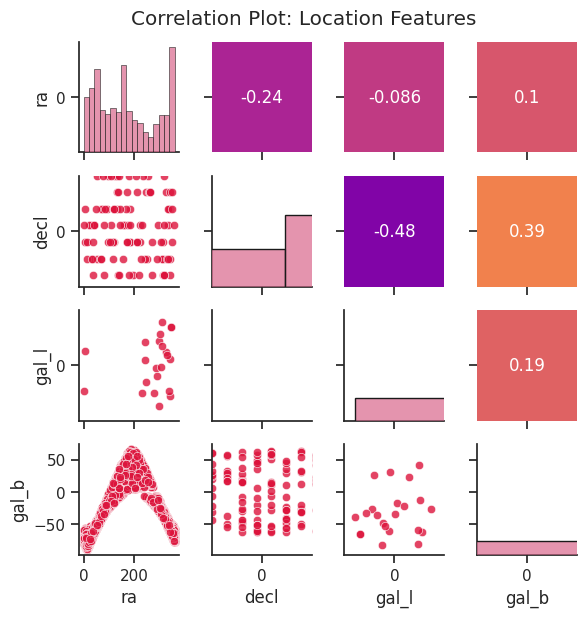

In [9]:
locFeatures = ['ra', 'decl', 'gal_l', 'gal_b']
locData = metaData[locFeatures]

def corrMatrix(x, y, **kwargs):
  #Function to plot correlation matrix.
  corr = x.corr(y)
  sns.heatmap([[corr]], cmap='plasma', annot=True, cbar=False, vmin=-1, vmax=1)

#PairGrid with scatterplots on the lower diagonal | corr score on the upper diagonal | histogram on diagonal.
sns.set_theme(style="ticks")
plot1 = sns.PairGrid(locData, height=1.5, aspect=1)
plot1.map_lower(sns.scatterplot, alpha=0.8, color = 'crimson')
plot1.map_upper(corrMatrix)
plot1.map_diag(sns.histplot, color = 'palevioletred', edgecolor = 'k')
plt.suptitle("Correlation Plot: Location Features", y=1.02)
plt.show()

### Histogram to see distribution.

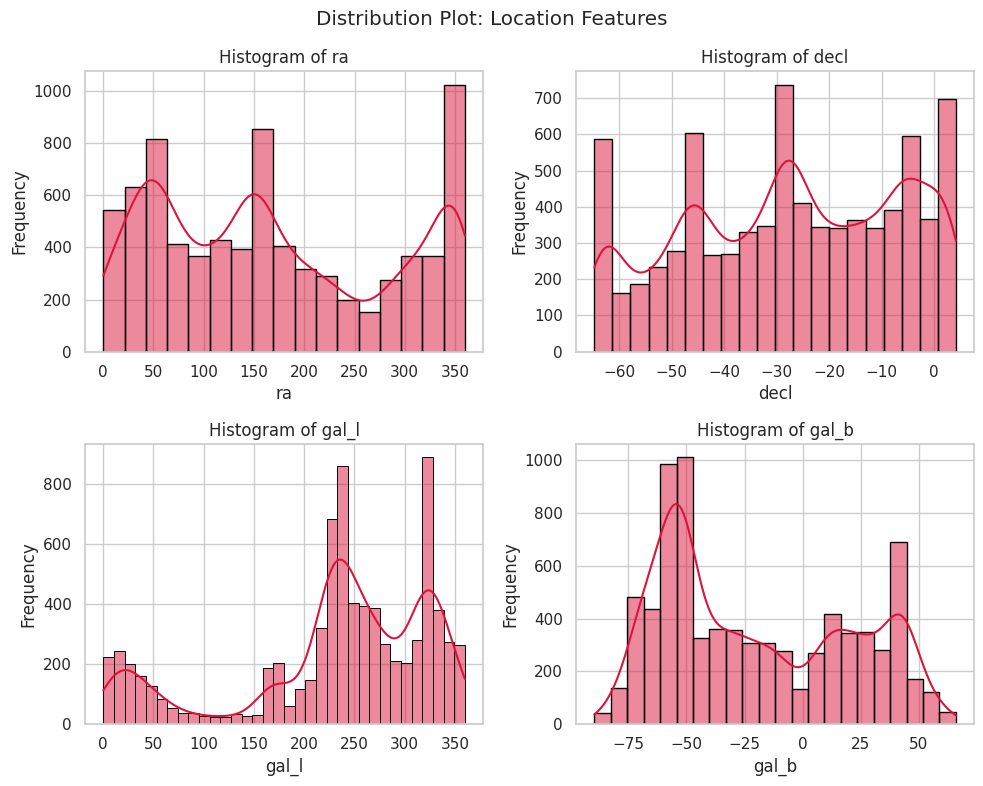

In [ ]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axes = axes.flatten()

#Histograms for each variable.
for i, var in enumerate(locFeatures):
  sns.histplot(data=metaData, x=var, kde=True, ax=axes[i], color='crimson', edgecolor='black')

  axes[i].set_xlabel(f'{var}')
  axes[i].set_ylabel('Frequency')
  axes[i].set_title(f'Histogram of {var}')

plt.suptitle("Distribution Plot: Location Features")
plt.tight_layout()
plt.show()

### Motion Characteristic Data.

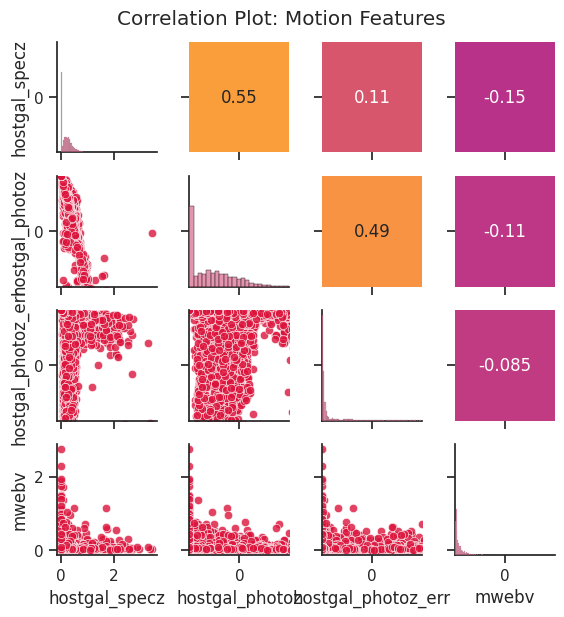

In [ ]:
charFeatures = ['hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 'mwebv']
charData = metaData[charFeatures]

def corrMatrix(x, y, **kwargs):
  '''Function to plot correlation matrix.'''
  corr = x.corr(y)
  sns.heatmap([[corr]], cmap='plasma', annot=True, cbar=False, vmin=-1, vmax=1)

#PairGrid with scatterplots on the lower diagonal | corr score on the upper diagonal | histogram on diagonal.
sns.set_theme(style="ticks")
plot1 = sns.PairGrid(charData, height=1.5, aspect=1)
plot1.map_lower(sns.scatterplot, alpha=0.8, color = 'crimson')
plot1.map_upper(corrMatrix)
plot1.map_diag(sns.histplot, color = 'palevioletred', edgecolor = 'k')
plt.suptitle("Correlation Plot: Motion Features", y=1.02)
plt.show()

### Histogram to see distribution.

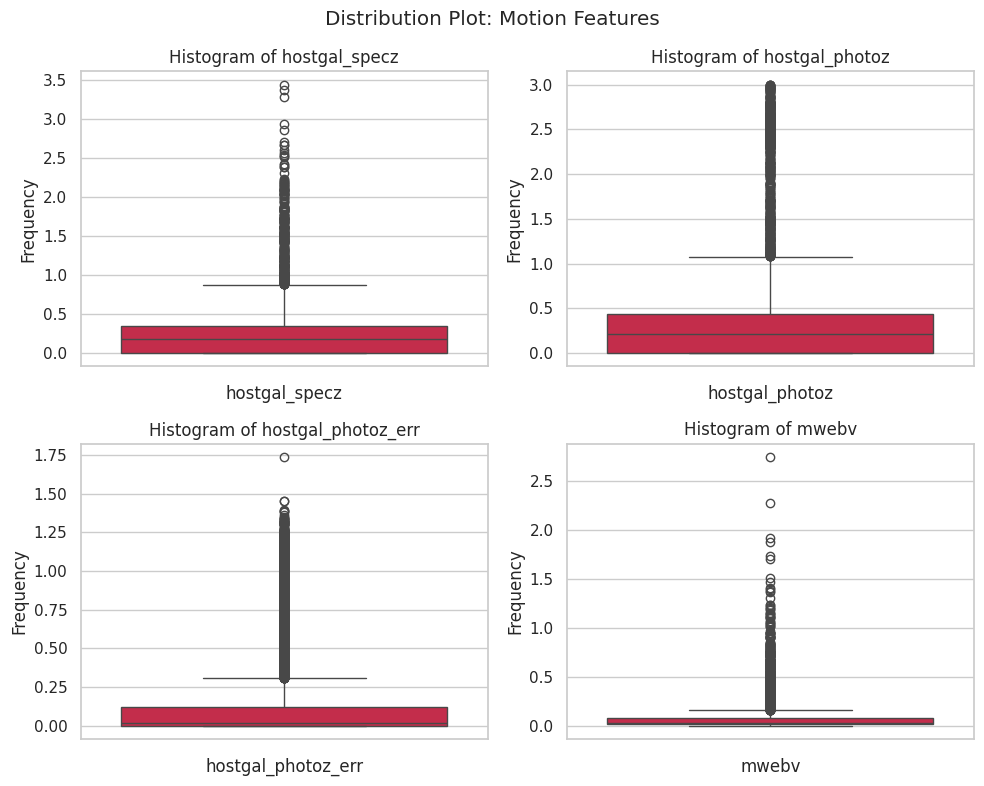

In [ ]:
sns.set_theme(style="whitegrid")
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(10, 8))
axes = axes.flatten()

#Histograms for each variable.
for i, var in enumerate(charFeatures):
  sns.boxplot(data=metaData, y=var, ax=axes[i], color='crimson')

  axes[i].set_xlabel(f'{var}')
  axes[i].set_ylabel('Frequency')
  axes[i].set_title(f'Histogram of {var}')

plt.suptitle("Distribution Plot: Motion Features")
plt.tight_layout()
plt.show()

### Time series data with information collected from the Large Synoptic Survey Telescope (LSST).

In [ ]:
trainData = pd.read_csv('training_set.csv', encoding = 'utf-8')
print(f'Original training data: Row - {trainData.shape[0]} | Column - {trainData.shape[1]}')
#Double check to make sure we have same number of object ID.--> Indeed we do!
print(f"Training Data: Number of Object ID: {trainData['object_id'].nunique()}")

Original training data: Row - 1421705 | Column - 6
Training Data: Number of Object ID: 7848


In [ ]:
trainData.head(5)

object_id         mjd  passband        flux   flux_err  detected
0        615  59750.4229         2 -544.810303   3.622952         1
1        615  59750.4306         1 -816.434326   5.553370         1
2        615  59750.4383         3 -471.385529   3.801213         1
3        615  59750.4450         4 -388.984985  11.395031         1
4        615  59752.4070         2 -681.858887   4.041204         1

In [ ]:
#Left join will automatically match object_id to corresponding class target value.
trainData = pd.merge(trainData, metaData[['object_id', 'target']], on='object_id', how='left')
print(f'Merged training data: Row - {trainData.shape[0]} | Column - {trainData.shape[1]}')
#Double check to make sure we have same number of object ID and Target Classes.--> Indeed we do!
print(f"Train Data: Number of Object ID: {trainData['object_id'].nunique()} | Number of Target Classes: {trainData['target'].nunique()}")

Merged training data: Row - 1421705 | Column - 7
Train Data: Number of Object ID: 7848 | Number of Target Classes: 14


In [ ]:
trainData.head(5)

object_id         mjd  passband        flux   flux_err  detected  target
0        615  59750.4229         2 -544.810303   3.622952         1      92
1        615  59750.4306         1 -816.434326   5.553370         1      92
2        615  59750.4383         3 -471.385529   3.801213         1      92
3        615  59750.4450         4 -388.984985  11.395031         1      92
4        615  59752.4070         2 -681.858887   4.041204         1      92

In [ ]:
#Create a dictionary to store all object_id with the same target class.
target_objectID_dict = trainData.groupby('target')['object_id'].unique().apply(list).to_dict()

print(f'Object IDs correspond to class target 53: {len(target_objectID_dict[53])} objects')
print(target_objectID_dict[53])

Object IDs correspond to class target 53: 30 objects
[133773, 268977, 278480, 288194, 2298767, 4416529, 4855013, 16504681, 17991828, 20578786, 24408486, 33834663, 55427870, 58557115, 74062905, 76475797, 93009853, 93620586, 97301909, 97943128, 99366334, 104765443, 105688990, 106195942, 108275496, 113409097, 114163906, 117510131, 118532728, 125642419]


### Convert mjd' time - Modified Julian Date to standard time.

In [ ]:
trainData['unix_time'] = (trainData['mjd'] - 40587) * 86400
#Addtionally, convert Unix epoch time to Datetime format.
trainData['datetime'] = pd.to_datetime(trainData['unix_time'], unit='s')
trainData = trainData.drop(columns=['mjd', 'unix_time'])
trainData.head(5)

object_id  passband        flux   flux_err  detected  target  \
0        615         2 -544.810303   3.622952         1      92   
1        615         1 -816.434326   5.553370         1      92   
2        615         3 -471.385529   3.801213         1      92   
3        615         4 -388.984985  11.395031         1      92   
4        615         2 -681.858887   4.041204         1      92   

                       datetime  
0 2022-06-20 10:08:58.559999744  
1 2022-06-20 10:20:03.840000000  
2 2022-06-20 10:31:09.120000000  
3 2022-06-20 10:40:48.000000000  
4 2022-06-22 09:46:04.800000000

### Merge Time Series Data (trainData) & Static Numerical Data (metaData).

In [ ]:
trainData = pd.merge(trainData, metaData, on='object_id', how='left')
#Drop 'dectected' --> More align with research objective. Will explain in the report.
trainData = trainData.drop(columns=['target_y', 'detected'])
trainData = trainData.rename(columns={'target_x': 'target'})
trainData.head(5)

object_id  passband        flux   flux_err  target  \
0        615         2 -544.810303   3.622952      92   
1        615         1 -816.434326   5.553370      92   
2        615         3 -471.385529   3.801213      92   
3        615         4 -388.984985  11.395031      92   
4        615         2 -681.858887   4.041204      92   

                       datetime          ra       decl      gal_l      gal_b  \
0 2022-06-20 10:08:58.559999744  349.046051 -61.943836  320.79653 -51.753706   
1 2022-06-20 10:20:03.840000000  349.046051 -61.943836  320.79653 -51.753706   
2 2022-06-20 10:31:09.120000000  349.046051 -61.943836  320.79653 -51.753706   
3 2022-06-20 10:40:48.000000000  349.046051 -61.943836  320.79653 -51.753706   
4 2022-06-22 09:46:04.800000000  349.046051 -61.943836  320.79653 -51.753706   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  mwebv  
0            0.0             0.0                 0.0  0.017  
1            0.0             0.0                 0.0  0.017  
2            0.0             0.0                 0.0  0.017  
3            0.0             0.0                 0.0  0.017  
4            0.0             0.0                 0.0  0.017

### Plot the distribution of 'target' variable --> There is **DATA IMBALANCE** issue. --> Will circle back to this below.

In [ ]:
def plotTarget_distribution(trainData):
  '''Function plot target distribution: unique Ibject ID count | total object ID count.'''
  #Count and sort the occurrences of each unique target value.
  target_object_id_counts = trainData.groupby('target')['object_id'].nunique()
  sorted_counts = target_object_id_counts.sort_values(ascending=True)

  #Create the map with tailored features to the data.
  fig, axes = plt.subplots(1, 2, figsize=(15, 6))
  cmap = plt.cm.plasma
  n_unique_target = len(sorted_counts)
  class_color = list(cmap(np.linspace(0, 1, n_unique_target)))[::-1]
  class_col_dict = dict(zip(sorted_counts.index, class_color))

  #Plot bar chart for unique object IDs per target value.
  ax1 = axes[0]
  indexes = np.arange(n_unique_target)
  width = 0.8
  bars1 = ax1.bar(indexes, sorted_counts, width, edgecolor='k', linewidth=1.5, log=True, color=[class_col_dict[label] for label in sorted_counts.index])
  ax1.set_xticks(indexes)
  ax1.set_xticklabels(sorted_counts.index, ha='right')
  ax1.set_xlabel('Class Target Values')
  ax1.set_ylabel('Number of Unique Object IDs')
  for bar, value in zip(bars1, sorted_counts):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width() / 2, height + 0.05 * height, str(value), ha='center', va='bottom', fontsize=8)
  ax1.set_title('Object ID Count for Each Target Value')

  #Plot bar chart for object ID count per target value.
  ax2 = axes[1]
  counts = Counter(trainData['target'])
  labels, values = zip(*sorted(counts.items(), key=itemgetter(1)))
  n_unique_target = len(labels)
  class_color = list(cmap(np.linspace(0, 1, n_unique_target)))[::-1]
  class_col_dict = dict(zip(labels, class_color))
  indexes = np.arange(n_unique_target)
  width = 0.8
  bars2 = ax2.bar(indexes, values, width, edgecolor='k', linewidth=1.5, log=True, color=class_color)
  ax2.set_xticks(indexes)
  ax2.set_xticklabels(labels, ha='right')
  ax2.set_xlabel('Class Target Values')
  ax2.set_ylabel('Number of Objects')
  for bar, value in zip(bars2, values):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width() / 2, height + 0.05 * height, str(value), ha='center', va='bottom', fontsize=8)
  ax2.set_title('Object ID Count for Each Target Value')

  plt.tight_layout()
  plt.show()

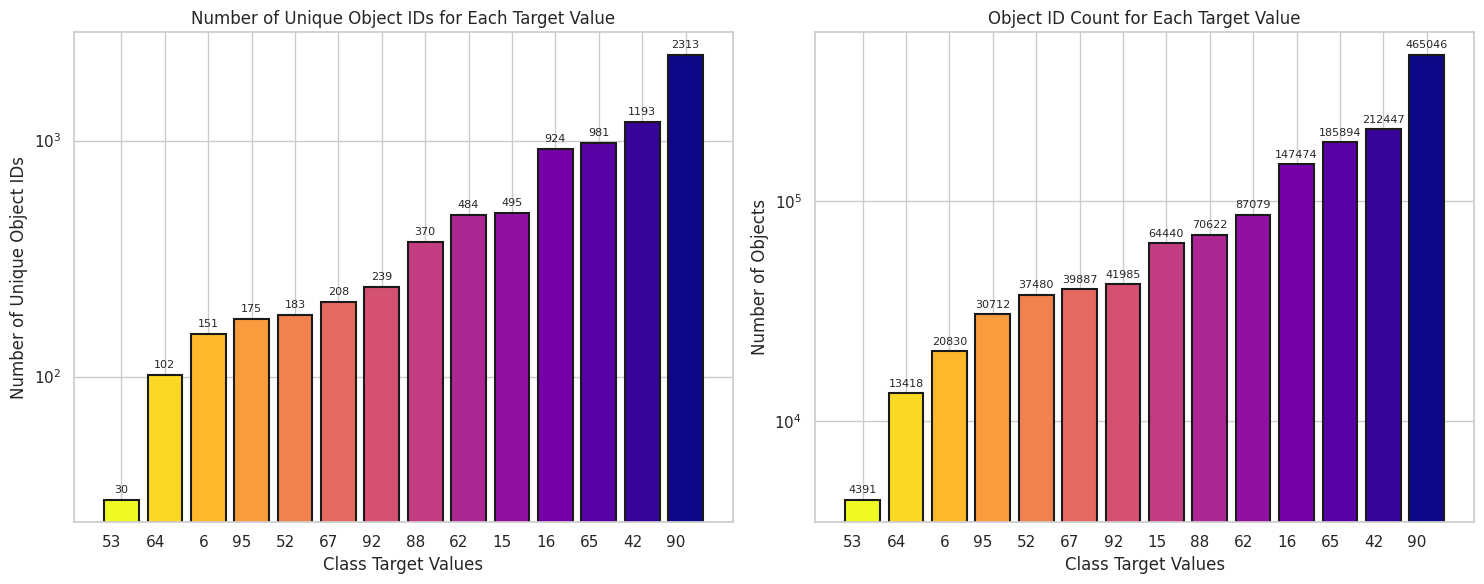

In [ ]:
plotTarget_distribution(trainData)

### Plot the distribution of 'flux' variable overtime --> Notice we have object with extra recorded time.

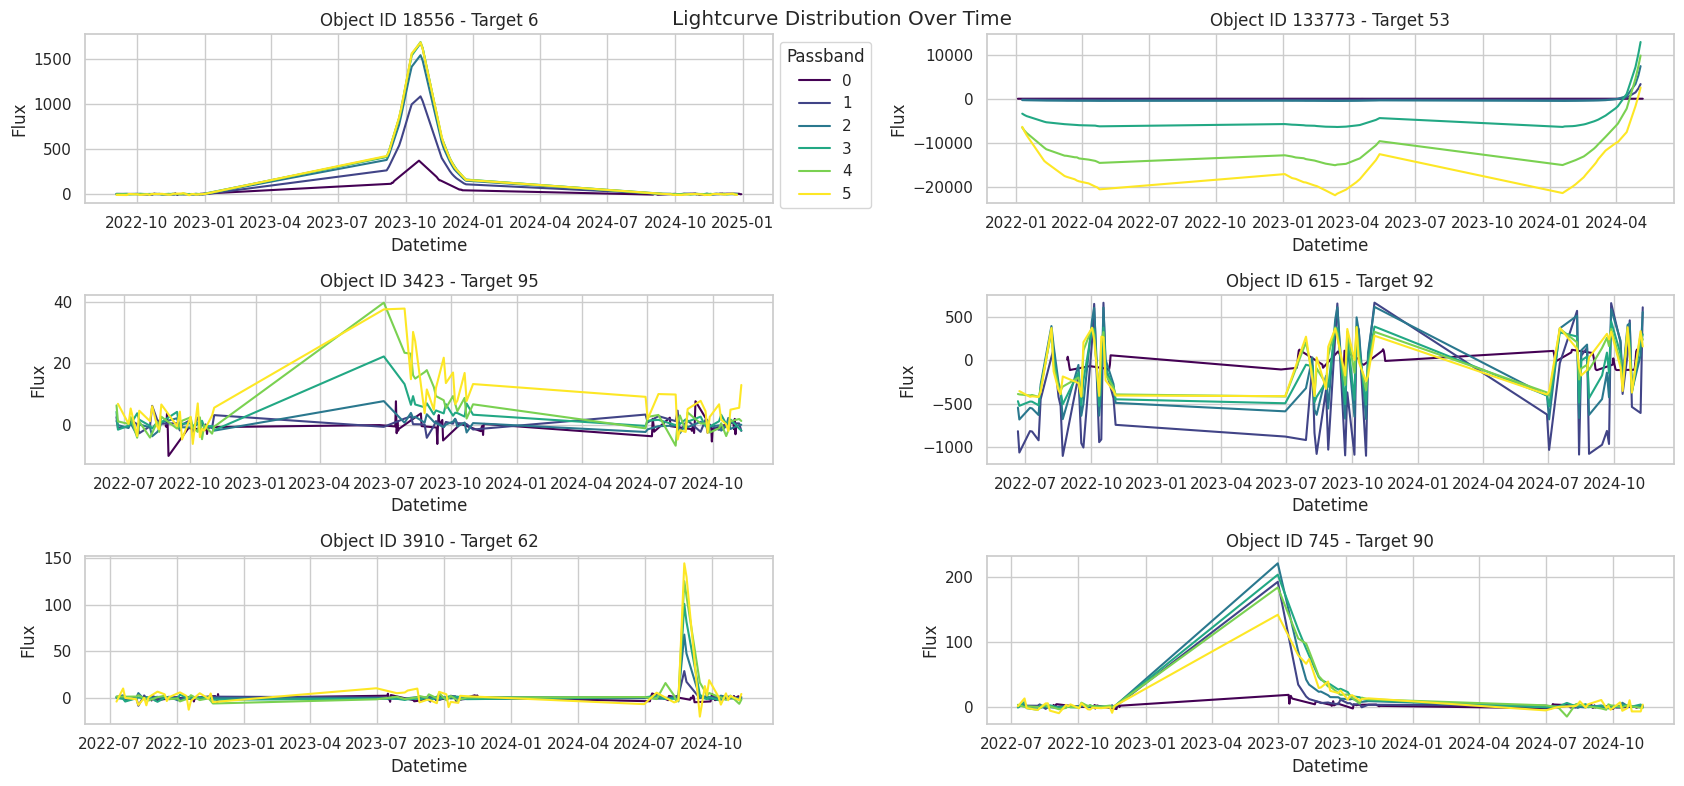

In [ ]:
sns.set_theme(style="whitegrid")
object_idList = [18556, 133773, 3423, 615, 3910, 745]
rows = (len(object_idList) + 1) // 2
cols = 2
fig, axes = plt.subplots(rows, cols, figsize=(17, 8))
axes = axes.flatten()

#Plot each lightcurve.
for i, objectID in enumerate(object_idList):
  selectedData = trainData[trainData['object_id'] == objectID]
  row = i // cols
  col = i % cols

  #Plotting the lightcurve with respect to passband.
  sns.lineplot(x='datetime', y='flux', hue='passband', data=selectedData, palette='viridis', ax=axes[i])
  axes[i].set_xlabel('Datetime')
  axes[i].set_ylabel('Flux')
  axes[i].set_title(f'Object ID {objectID} - Target {selectedData.iloc[0]["target"]}')

  #Display legend only in the first subplot.
  if i == 0:
    axes[i].legend(title='Passband', bbox_to_anchor=(1, 1), loc='upper left')
  else:
    axes[i].get_legend().remove()

plt.tight_layout()
plt.suptitle('Lightcurve Distribution Over Time')
plt.show()

### Process data further for ML. Data now have both Time Series and Static.

In [ ]:
#Make copy forward.
trainData2 = trainData.copy()
trainData2['datetime'] = trainData2['datetime'].astype(str)
trainData2['date'] = trainData2['datetime'].str.extract(r'(\d{4}-\d{2}-\d{2})')
trainData2.head(3)

object_id  passband        flux  flux_err  target  \
0        615         2 -544.810303  3.622952      92   
1        615         1 -816.434326  5.553370      92   
2        615         3 -471.385529  3.801213      92   

                        datetime          ra       decl      gal_l      gal_b  \
0  2022-06-20 10:08:58.559999744  349.046051 -61.943836  320.79653 -51.753706   
1  2022-06-20 10:20:03.840000000  349.046051 -61.943836  320.79653 -51.753706   
2  2022-06-20 10:31:09.120000000  349.046051 -61.943836  320.79653 -51.753706   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  mwebv        date  
0            0.0             0.0                 0.0  0.017  2022-06-20  
1            0.0             0.0                 0.0  0.017  2022-06-20  
2            0.0             0.0                 0.0  0.017  2022-06-20

### Tackle **CLASS IMBALANCE!**

In [ ]:
#Get total observation per Object ID for each target class.
targetClasses = trainData2['target'].unique()

for targetClass in targetClasses:
  targetData = trainData2[trainData2['target'] == targetClass]
  rowCounts = targetData.groupby('object_id').size()

  minRow_objectID = rowCounts.idxmin()
  maxRow_objectID = rowCounts.idxmax()

  print(f"Target {targetClass}:")
  print(f"Object ID with the minimum number of obs: {minRow_objectID} ({rowCounts[minRow_objectID]} rows)")
  print(f"Object ID with the maximum number of obs: {maxRow_objectID} ({rowCounts[maxRow_objectID]} rows)\n")


Target 92:
Object ID with the minimum number of obs: 119353712 (52 rows)
Object ID with the maximum number of obs: 615 (352 rows)

Target 88:
Object ID with the minimum number of obs: 110850947 (56 rows)
Object ID with the maximum number of obs: 7409 (352 rows)

Target 42:
Object ID with the minimum number of obs: 86237249 (50 rows)
Object ID with the maximum number of obs: 1632 (352 rows)

Target 90:
Object ID with the minimum number of obs: 49575267 (47 rows)
Object ID with the maximum number of obs: 1124 (352 rows)

Target 65:
Object ID with the minimum number of obs: 57679220 (69 rows)
Object ID with the maximum number of obs: 2624 (352 rows)

Target 16:
Object ID with the minimum number of obs: 100413487 (55 rows)
Object ID with the maximum number of obs: 15626 (352 rows)

Target 67:
Object ID with the minimum number of obs: 51008084 (76 rows)
Object ID with the maximum number of obs: 2922 (352 rows)

Target 95:
Object ID with the minimum number of obs: 50118260 (55 rows)
Object I

### Class imbalance: Convert into time-rolled-out instance.
### To ensure that each object ID has the same number of observed rows/time steps --> Create sequences of uniform length.
### With respect to objectID: Get the appropriate MAXIMUM of minimum number of obs (95). Target '53' has the least amount of Object ID.

In [ ]:
rowCounts = trainData2.groupby('object_id').size()
#Object IDs with at least 95 observations
valid_objectIDs = rowCounts[rowCounts >= 95].index
trainData3 = trainData2[trainData2['object_id'].isin(valid_objectIDs)]
print(f"Train Data (After removing small obs): Number of unique object ID: {trainData3['object_id'].nunique()} | Number of Target Classes: {trainData3['target'].nunique()}")
trainData3.tail(3)

Train Data (After removing small obs): Number of unique object ID: 7675 | Number of Target Classes: 14


object_id  passband       flux   flux_err  target  \
1421702  130779836         5  30.593130  50.695290       6   
1421703  130779836         4 -23.471439  44.819859       6   
1421704  130779836         0 -41.214264  51.665123       6   

                              datetime          ra       decl      gal_l  \
1421702  2024-09-18 00:32:24.000000000  301.992188 -17.426323  25.102988   
1421703  2024-10-02 23:56:15.360000256  301.992188 -17.426323  25.102988   
1421704  2024-10-05 00:53:34.080000000  301.992188 -17.426323  25.102988   

             gal_b  hostgal_specz  hostgal_photoz  hostgal_photoz_err  mwebv  \
1421702 -24.511101            0.0             0.0                 0.0  0.091   
1421703 -24.511101            0.0             0.0                 0.0  0.091   
1421704 -24.511101            0.0             0.0                 0.0  0.091   

               date  
1421702  2024-09-18  
1421703  2024-10-02  
1421704  2024-10-05

### For object IDs that have more than 95 observation rows. Narrow down to exactly 95 rows.

In [ ]:
#Get the first 95 latest observations.
trainData4=trainData3.copy()
trainData4.sort_values(by=['object_id', 'datetime'], ascending=[True, False], inplace=True)
trainData4 = trainData4.groupby('object_id').head(95).copy()
trainData4.reset_index(drop=True, inplace=True)
print(f'Training data (Uniform observations length): Row - {trainData4.shape[0]} | Column - {trainData4.shape[1]}')
#Cut half of the data size.
trainData4.head(5)

Training data (Uniform observations length): Row - 729125 | Column - 15


object_id  passband        flux  flux_err  target  \
0        615         5  157.080200  8.453112      92   
1        615         4  235.489929  3.926538      92   
2        615         3  296.946533  3.475000      92   
3        615         1  607.047668  5.140991      92   
4        615         2  552.150269  3.917989      92   

                        datetime          ra       decl      gal_l      gal_b  \
0  2024-11-10 05:07:00.479999744  349.046051 -61.943836  320.79653 -51.753706   
1  2024-11-10 04:51:10.080000000  349.046051 -61.943836  320.79653 -51.753706   
2  2024-11-10 04:35:28.320000000  349.046051 -61.943836  320.79653 -51.753706   
3  2024-11-10 04:24:23.039999744  349.046051 -61.943836  320.79653 -51.753706   
4  2024-11-10 04:13:26.399999744  349.046051 -61.943836  320.79653 -51.753706   

   hostgal_specz  hostgal_photoz  hostgal_photoz_err  mwebv        date  
0            0.0             0.0                 0.0  0.017  2024-11-10  
1            0.0             0.0                 0.0  0.017  2024-11-10  
2            0.0             0.0                 0.0  0.017  2024-11-10  
3            0.0             0.0                 0.0  0.017  2024-11-10  
4            0.0             0.0                 0.0  0.017  2024-11-10

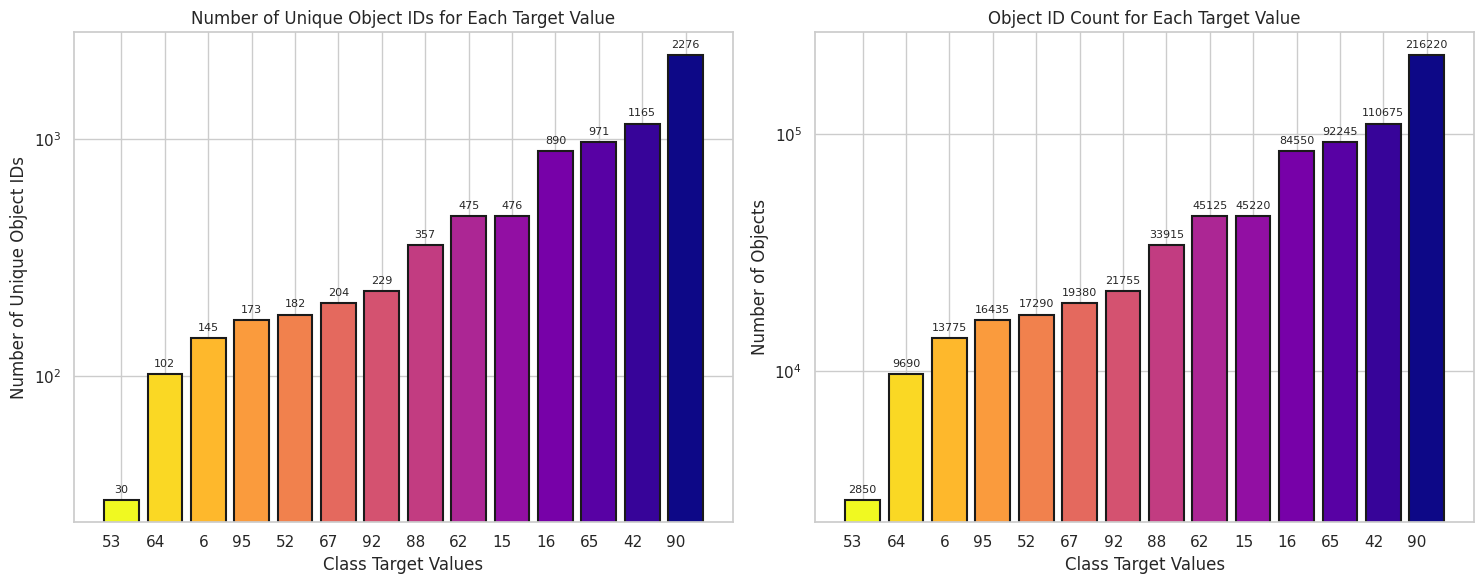

In [ ]:
#Still the same distribution as original.
plotTarget_distribution(trainData4)

### **Apply Time Roll Out**
### Train-Test Split.

In [ ]:
#Ensure class target distribution is preserved in both sets.
trainData5, testData = train_test_split(trainData4, test_size=0.35, random_state=1997, stratify=trainData4['target'])

print(f'Size of train data: Row - {trainData5.shape[0]} | Column - {trainData5.shape[1]}')
print(f'Size of test data: Row - {testData.shape[0]} | Column - {testData.shape[1]}')

Size of train data: Row - 473931 | Column - 15
Size of test data: Row - 255194 | Column - 15


In [ ]:
def timeSeries_rollout(data, timeStep):
  '''Function to perform time series roll-out.'''
  rolled_outData = []
  rolloutCols = ['flux', 'flux_err']

  for col in rolloutCols:
    for t in range(timeStep):
      new_col_name = f'{col}_t{t}'
      data[new_col_name] = data.groupby('object_id')[col].shift(-t)

    rolled_outData.append(new_col_name)

  #Drop NaN values after the last observation for each object ID
  data.dropna(subset=rolled_outData, inplace=True)

  return data

In [ ]:
#Time roll out train data.
timeStep = 5
trainData_rollout = timeSeries_rollout(trainData5, timeStep)
trainData_rollout_OBJ = trainData_rollout.drop(columns=['datetime', 'date', 'flux', 'flux_err', 'passband'])
trainData_rollout = trainData_rollout.drop(columns=['datetime', 'date', 'flux', 'flux_err', 'passband', 'object_id'])

# Display the resulting DataFrame
print(f'Size of train data (with time roll out): Row - {trainData_rollout.shape[0]} | Column - {trainData_rollout.shape[1]}')
print(f'Time rolled out train data missing value: {trainData_rollout.isna().sum()[trainData_rollout.isna().sum() > 0]}')
trainData_rollout.head(5)

Size of train data (with time roll out): Row - 443231 | Column - 19
Time rolled out train data missing value: Series([], dtype: int64)


target          ra       decl       gal_l      gal_b  hostgal_specz  \
625478      42    2.285156 -16.957764   76.874741 -75.890074         0.1884   
69609       42   53.613281 -28.630989  225.073365 -54.119461         0.2230   
645440       6  182.109375 -54.340912  296.627740   8.003654         0.0000   
563603      90  205.839844  -8.385539  324.251754  52.323760         0.1561   
607146      16   78.750000  -9.745426  210.835904 -25.815987         0.0000   

        hostgal_photoz  hostgal_photoz_err  mwebv    flux_t0    flux_t1  \
625478          0.1647              0.1066  0.026  -9.197116 -28.945868   
69609           0.2219              0.1530  0.006   0.865794  12.118377   
645440          0.0000              0.0000  0.168  86.493896   9.084106   
563603          0.1564              0.6484  0.042  79.232697  -1.729469   
607146          0.0000              0.0000  0.144  -8.114159   7.421710   

          flux_t2    flux_t3    flux_t4  flux_err_t0  flux_err_t1  \
625478  -3.691269  -3.227240   2.507751    10.882568    32.498875   
69609    8.227738  49.808361  53.610195     1.876585     1.118521   
645440   0.649102 -11.940648   4.200133     6.109391    20.415337   
563603  41.465374  -6.143471   9.888044     6.923542     3.187884   
607146 -31.626654  -6.883346 -10.778863     5.552737    14.901764   

        flux_err_t2  flux_err_t3  flux_err_t4  
625478    24.996227     4.942544     2.143798  
69609      1.562590     3.717698     5.097389  
645440    24.076883    10.529382    18.975220  
563603     3.879384     5.225923     6.450335  
607146    32.646160    10.222394    14.797212

In [ ]:
#Create xTrain, yTrain. NO DOWN SAMPLED!
xTrain = trainData_rollout.drop(columns=['target'])
yTrain = trainData_rollout['target']
yTrain = yTrain.astype('category')

print("Shape of xTrain:", xTrain.shape)
print("Shape of yTrain:", yTrain.shape)
print("Data type of yTrain:", yTrain.dtype)

Shape of xTrain: (443231, 18)
Shape of yTrain: (443231,)
Data type of yTrain: category


In [ ]:
#Time roll out test data.
timeStep = 5
testData_rollout = timeSeries_rollout(testData, timeStep)
testData_rollout_OBJ = testData_rollout.drop(columns=['datetime', 'date', 'flux', 'flux_err', 'passband'])
testData_rollout = testData_rollout.drop(columns=['datetime', 'date', 'flux', 'flux_err', 'passband', 'object_id'])

# Display the resulting DataFrame
print(f'Size of train data (with time roll out): Row - {testData_rollout.shape[0]} | Column - {testData_rollout.shape[1]}')
print(f'Time rolled out test data missing value: {testData_rollout.isna().sum()[testData_rollout.isna().sum() > 0]}')
testData_rollout.head(5)

Size of train data (with time roll out): Row - 224494 | Column - 19
Time rolled out test data missing value: Series([], dtype: int64)


target          ra       decl       gal_l      gal_b  hostgal_specz  \
576881      42   18.632812 -16.801838  151.475200 -78.373139         0.9098   
219075      42  141.909454 -42.210369  267.575861   6.254172         0.1460   
84818       65   53.261719 -27.615883  223.280041 -54.281374         0.0000   
157519      90  347.013428 -62.508568  321.472056 -50.735330         0.6261   
490059      90  202.851562 -26.443335  313.943261  35.572368         0.3595   

        hostgal_photoz  hostgal_photoz_err  mwebv    flux_t0     flux_t1  \
576881          0.9193              0.0526  0.020  -7.963702    0.926163   
219075          0.1532              0.0148  0.372 -16.632029   -7.331076   
84818           0.0000              0.0000  0.006 -10.879652  359.949982   
157519          0.7054              0.0490  0.018   0.165906    2.037328   
490059          0.3690              0.2735  0.054  -6.710560   37.185448   

          flux_t2     flux_t3   flux_t4  flux_err_t0  flux_err_t1  \
576881  -5.108488    0.325155 -0.435653     8.997500    10.206300   
219075 -19.374369   -0.546301  6.309095    21.257053     4.765378   
84818    0.000678  107.924072 -2.766210     8.813211     2.494760   
157519   1.157739   -1.217017 -2.944920     0.927398     2.974084   
490059   0.807429   59.338249 -5.162223     6.600736    10.002114   

        flux_err_t2  flux_err_t3  flux_err_t4  
576881     8.436886    11.758633     7.299280  
219075    51.367977    14.020020    15.121450  
84818      0.961089    11.142174     1.712145  
157519     1.600325     4.558657     1.327266  
490059     2.843844    18.825476     7.347428

In [ ]:
#Create xTest, yTest. NO DOWN SAMPLED!
xTest = testData_rollout.drop(columns=['target'])
yTest = testData_rollout['target']
yTest = yTest.astype('category')

print("Shape of xTest:", xTest.shape)
print("Shape of yTest:", yTest.shape)
print("Data type of yTest:", yTest.dtype)

Shape of xTest: (224494, 18)
Shape of yTest: (224494,)
Data type of yTest: category


In [ ]:
#Get unique 'target' value count of each set.
class_distributionTrain = yTrain.value_counts()
class_distributionTest = yTest.value_counts()

#Calculate percentage for each 'target' class within training and validation sets.
percTrain = (class_distributionTrain / class_distributionTrain.sum()) * 100
percTest = (class_distributionTest / class_distributionTest.sum()) * 100

class_distributionTrain_table = pd.DataFrame({
    'Class': percTrain.index,
    '% in Training Set': percTrain.values})

class_distributionTest_table = pd.DataFrame({
    'Class': percTest.index,
    '% in Testing Set': percTest.values})

#Transpose DataFrames to display.
class_distributionTrain_table = class_distributionTrain_table.set_index('Class').T.round(3).astype(float)
class_distributionTest_table = class_distributionTest_table.set_index('Class').T.round(3).astype(float)

print("Class Distribution in Training Set:")
display(class_distributionTrain_table)

print("Class Distribution in Testing Set:")
display(class_distributionTest_table)

Class Distribution in Training Set:


Class                  90      42      65      16     15     62     88     92  \
% in Training Set  29.655  15.179  12.651  11.596  6.202  6.189  4.652  2.984   

Class                 67     52     95      6     64     53  
% in Training Set  2.658  2.371  2.254  1.889  1.329  0.391

Class Distribution in Testing Set:


Class                 90      42      65      16     15     62     88     92  \
% in Testing Set  29.655  15.179  12.652  11.596  6.202  6.189  4.651  2.984   

Class                67     52     95      6     64     53  
% in Testing Set  2.658  2.372  2.254  1.889  1.329  0.391

###**Further/Advanced Development: Data balancing.**
####Apply Downsampling and Upweighting - Google Machine Learning reference.
**Step 1: Downsample the majority classes.**

## **--TRAIN DATA--**

From 'target' class distribution plot above (on the whole dataset), class '90' has the most: 13,682 Object IDs, while class '53' has the least of 176 unique Object IDs. That is roughly 1 of class '53' to 77 objects in class '90'. Same logic apply to other classes in between. Given this, for '90', apply downsampling by a factor of 75 to improve the balance. Now, 1 of class 'c-95' to approximately 1.2 of 'c-90'. We will apply the same downsampling factor logic to other classes as well.

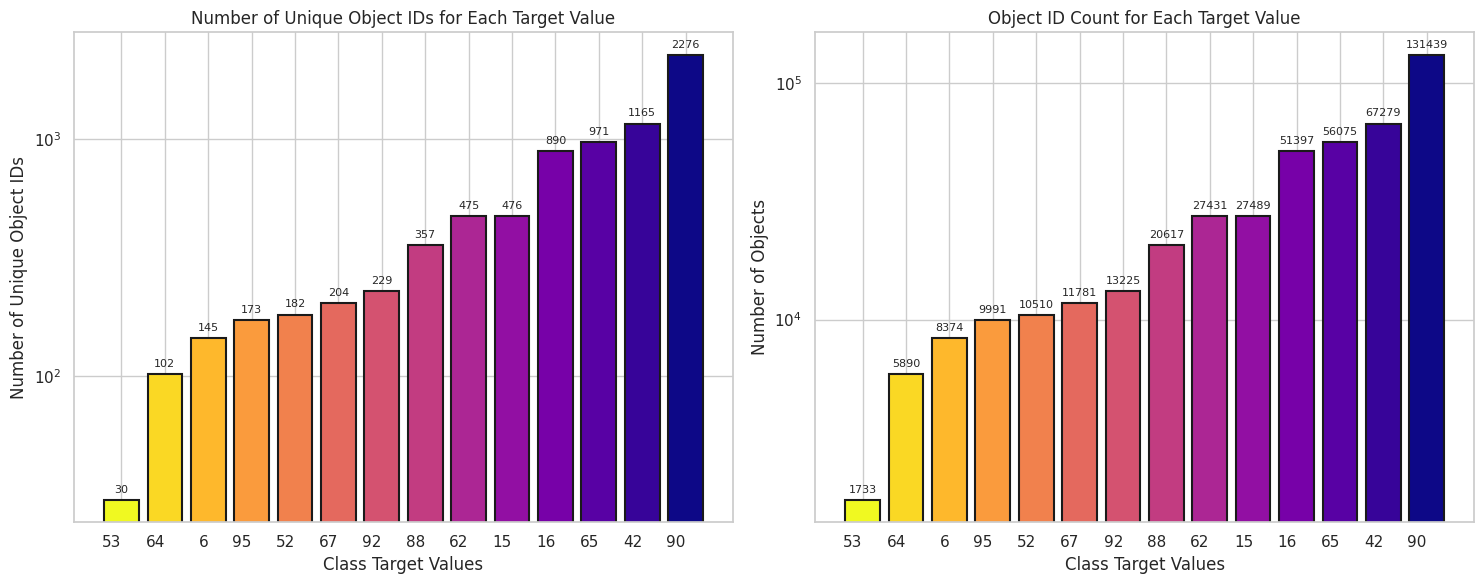

In [ ]:
#Get the distribution for time roll out trainData.
plotTarget_distribution(trainData_rollout_OBJ)

In [ ]:
def downsampleData(data, downsamplingFactors):
  '''Downsample the data according to specified downsampling factors for each target class.'''

  downsampledData = pd.DataFrame()
  for targetClass, factor in downsamplingFactors.items():
    #Get rows belonging to the current class.
    classInstances = data[data['target'] == targetClass]
    #Get number of instances to keep.
    keepInstances = len(classInstances) // factor
    #Random sample.
    downsampledInstances = classInstances.sample(n=keepInstances, random_state=1997)
    downsampledData = pd.concat([downsampledData, downsampledInstances], ignore_index=True)
  downsampledData = downsampledData.sample(frac=1, random_state=1997).reset_index(drop=True)
  return downsampledData

In [ ]:
#Tackle train set.
downsamplingFactors = {90: 20, 42: 11, 65: 10, 16: 10, 15: 6, 62: 6, 88: 5, 92: 4, 67: 4, 52: 4, 95: 4, 6: 4, 64: 3, 53: 1}
downsampled_trainData_rollout = downsampleData(trainData_rollout, downsamplingFactors)

print("Original dataset shape:", trainData_rollout.shape)
print("Downsampled dataset shape:", downsampled_trainData_rollout.shape)
print("Class Distribution - post down sampled:")
print(downsampled_trainData_rollout['target'].value_counts())

Original dataset shape: (443231, 19)
Downsampled dataset shape: (53872, 19)
Class Distribution - post down sampled:
90    6571
42    6116
65    5607
16    5139
15    4581
62    4571
88    4123
92    3306
67    2945
52    2627
95    2497
6     2093
64    1963
53    1733
Name: target, dtype: int64


In [ ]:
def plot_targetFrequency(downsampledData, origData):
    '''Plot frequency count of each target value before and after downsampled.'''

    downsampledData['target'] = downsampledData['target'].astype(str)
    origData['target'] = origData['target'].astype(str)

    downsampled_target_uniqueCounts = downsampledData['target'].value_counts()
    target_uniqueCounts = origData['target'].value_counts()

    downsampled_target_uniqueCounts_sorted = downsampled_target_uniqueCounts.sort_values()
    target_uniqueCounts_sorted = target_uniqueCounts.sort_values()

    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    #1st Plot: Downsampled data.
    axs[0].bar(downsampled_target_uniqueCounts_sorted.index, downsampled_target_uniqueCounts_sorted.values, color=plt.cm.plasma_r(np.linspace(0, 1, len(downsampled_target_uniqueCounts_sorted))))

    for i, v in enumerate(downsampled_target_uniqueCounts_sorted.values):
        axs[0].text(i, v + 0.025 * max(downsampled_target_uniqueCounts_sorted.values), str(v), ha='center', va='bottom', fontsize=8)

    axs[0].set_xlabel('Target Values')
    axs[0].set_ylabel('Frequency')
    axs[0].set_title('Frequency Count of Each Target Value (Downsampled)')

    #2nd Plot: Original data.
    axs[1].bar(target_uniqueCounts_sorted.index, target_uniqueCounts_sorted.values, color=plt.cm.plasma_r(np.linspace(0, 1, len(target_uniqueCounts_sorted))))

    for i, v in enumerate(target_uniqueCounts_sorted.values):
        axs[1].text(i, v + 0.025 * max(target_uniqueCounts_sorted.values), str(v), ha='center', va='bottom', fontsize=8)

    axs[1].set_xlabel('Target Values')
    axs[1].set_ylabel('Frequency')
    axs[1].set_title('Frequency Count of Each Target Value (Original)')

    plt.tight_layout()
    plt.show()

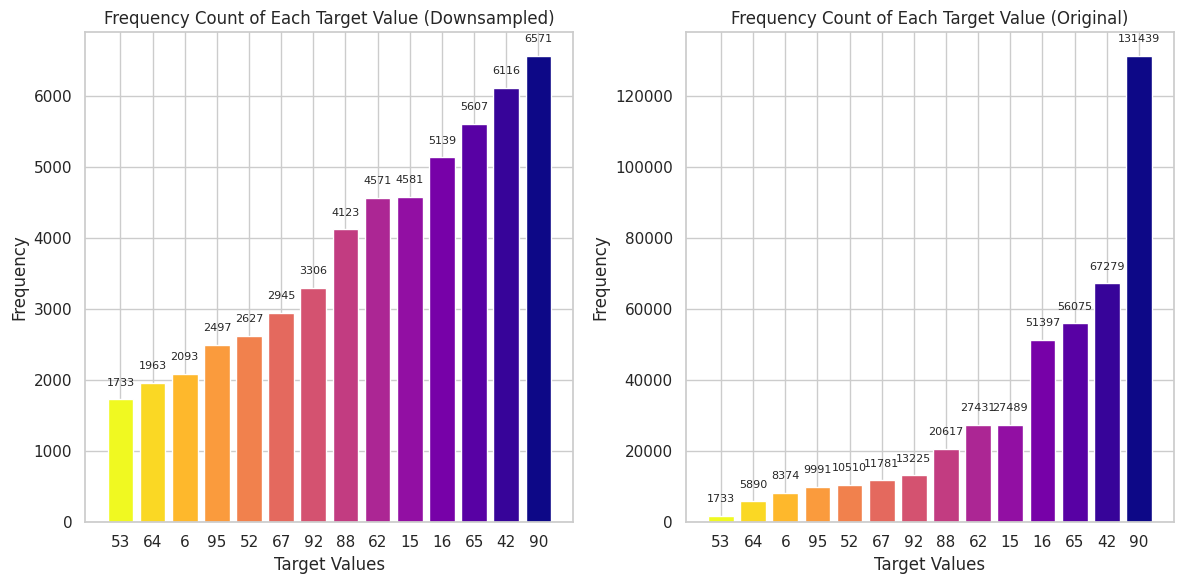

In [ ]:
plot_targetFrequency(downsampled_trainData_rollout, trainData_rollout)

In [ ]:
#Create xTrain, yTrain. WITH DOWN SAMPLED!
xTrain_ds = downsampled_trainData_rollout.drop(columns=['target'])
yTrain_ds = downsampled_trainData_rollout['target']
yTrain_ds = yTrain_ds.astype('category')

print("Shape of xTrain:", xTrain_ds.shape)
print("Shape of yTrain:", yTrain_ds.shape)
print("Data type of yTrain:", yTrain_ds.dtype)

Shape of xTrain: (53872, 18)
Shape of yTrain: (53872,)
Data type of yTrain: category


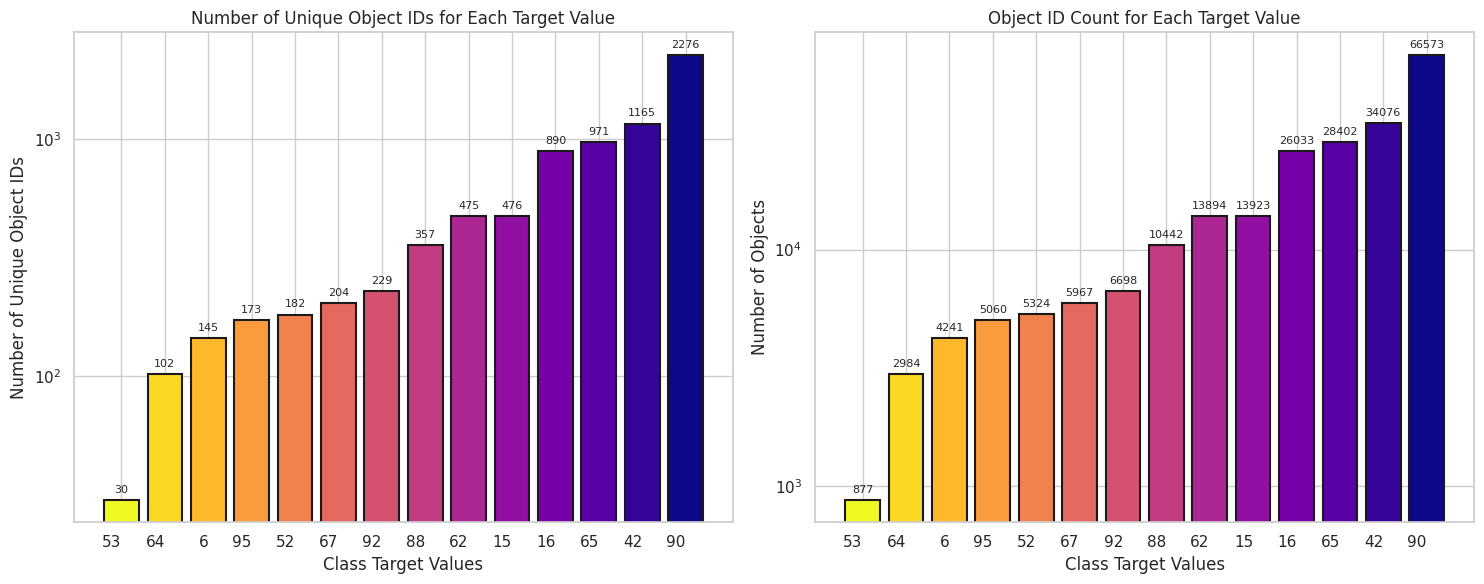

In [ ]:
#Get the distribution for time roll out testData.
plotTarget_distribution(testData_rollout_OBJ)

In [ ]:
#Tackle test set.
downsampled_testData_rollout = downsampleData(testData_rollout, downsamplingFactors)

print("Original dataset shape:", testData_rollout.shape)
print("Downsampled dataset shape:", downsampled_testData_rollout.shape)
print("Class Distribution - post down sampled:")
print(downsampled_testData_rollout['target'].value_counts())

Original dataset shape: (224494, 19)
Downsampled dataset shape: (27283, 19)
Class Distribution - post down sampled:
90    3328
42    3097
65    2840
16    2603
15    2320
62    2315
88    2088
92    1674
67    1491
52    1331
95    1265
6     1060
64     994
53     877
Name: target, dtype: int64


In [ ]:
#Create xTest, yTest. WITH DOWN SAMPLED!
xTest_ds = downsampled_testData_rollout.drop(columns=['target'])
yTest_ds = downsampled_testData_rollout['target']
yTest_ds = yTest_ds.astype('category')

print("Shape of xTest:", xTest_ds.shape)
print("Shape of yTest:", yTest_ds.shape)
print("Data type of yTest:", yTest_ds.dtype)

Shape of xTest: (27283, 18)
Shape of yTest: (27283,)
Data type of yTest: category


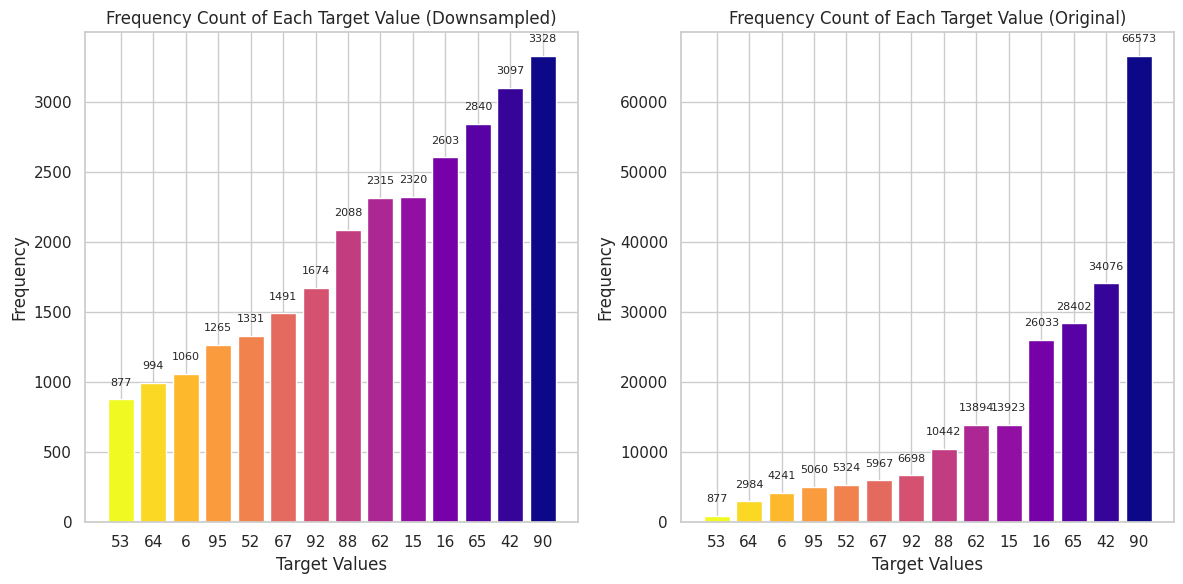

In [ ]:
plot_targetFrequency(downsampled_testData_rollout, testData_rollout)

## **--BUILD MODELS--**
**RANDOM FOREST CLASSIFIER - Grid Search - Full Data.**

In [ ]:
def logLoss(yTest, yPred, sample_weight=None):
  '''Calculate the log loss given actual versus predicted labels.'''

  uniqueClasses = sorted(list(set(yTest) | set(yPred)))
  yPred_oneHot = np.zeros((len(yPred), len(uniqueClasses)))
  for i, pred in enumerate(yPred):
    yPred_oneHot[i, uniqueClasses.index(pred)] = 1

  yTest_oneHot = np.zeros((len(yTest), len(uniqueClasses)))
  for i, true_label in enumerate(yTest):
    yTest_oneHot[i, uniqueClasses.index(true_label)] = 1

  return log_loss(yTest_oneHot, yPred_oneHot, sample_weight=sample_weight)

In [ ]:
#---WITH CROSS-VALIDATION!---
#Parameters Tuning.
paramDict = {'criterion': ['gini', 'entropy']}

resultsData_RFC = pd.DataFrame(columns=['Criterion', 'Accuracy', 'Log_Loss', 'Runtime'])

for criterion in paramDict['criterion']:
  startTime = time.time()
  rfClassifier = RandomForestClassifier(n_estimators=100, criterion=criterion, random_state=1997)
  #Cross-validation.
  scores = cross_val_score(rfClassifier, xTrain, yTrain, cv=5, scoring='accuracy')
  accuracy = scores.mean()

  #Fit the model.
  rfClassifier.fit(xTrain, yTrain)
  #Predict.
  yPred = rfClassifier.predict(xTest)

  #Calculate log loss.
  logloss = logLoss(yTest, yPred)
  runTime = time.time() - startTime

  resultsData_RFC = resultsData_RFC.append({
                'Criterion': criterion,
                'Accuracy': accuracy,
                'Log_Loss': logloss,
                'Runtime': runTime}, ignore_index=True)

display(resultsData_RFC)

Criterion  Accuracy  Log_Loss      Runtime
0      gini  0.968527  1.054847  2295.272728
1   entropy  0.974020  0.873420  3256.859522

In [ ]:
#---WITHOUT CROSS-VALIDATION!---
#Parameters Tuning.
paramDict = {'criterion': ['gini', 'entropy']}
resultsData_RFC_noCV = pd.DataFrame(columns=['Criterion', 'Accuracy', 'Log_Loss', 'Runtime'])
for criterion in paramDict['criterion']:
  startTime = time.time()
  rfClassifier = RandomForestClassifier(n_estimators=100, criterion=criterion, random_state=1997)
  #Fit the model.
  rfClassifier.fit(xTrain, yTrain)
  yPred = rfClassifier.predict(xTest)
  #Calculate accuracy.
  accuracy = accuracy_score(yTest, yPred)
  #Calculate log loss.
  logloss = logLoss(yTest, yPred)
  runTime = time.time() - startTime

  resultsData_RFC_noCV = resultsData_RFC_noCV.append({
        'Criterion': criterion,
        'Accuracy': accuracy,
        'Log_Loss': logloss,
        'Runtime': runTime}, ignore_index=True)

display(resultsData_RFC_noCV)

Criterion  Accuracy  Log_Loss     Runtime
0      gini  0.970734  1.054847  459.186801
1   entropy  0.975768  0.873420  696.432265

**RANDOM FOREST CLASSIFIER - Feature Selection with Best Model - Full Data.**

In [ ]:
fsFeatures = ['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 'mwebv']

#Use'gini' due to shorter run times. Similar Acc.
bestModel_RFC = RandomForestClassifier(n_estimators=100,
                                       criterion = 'gini',
                                       random_state=1997)

#Filter the features to include only those in fsFeatures.
xTrain_fs = xTrain[fsFeatures]
bestModel_RFC.fit(xTrain_fs, yTrain)

#Create SelectFromModel instance with the pre-fit best model.
selectorRFC = SelectFromModel(estimator=bestModel_RFC, threshold='mean', prefit=True)
xTrain_selected_RFC = selectorRFC.transform(xTrain_fs)

selectedIndices = selectorRFC.get_support(indices=True)
selected_featureNames = [fsFeatures[i] for i in selectedIndices]
not_selected_featureNames = [feat for feat in fsFeatures if feat not in selected_featureNames]

print("Selected Features:")
print(selected_featureNames)
print("\nNot Selected Features:")
print(not_selected_featureNames)

Selected Features:
['hostgal_specz', 'hostgal_photoz']

Not Selected Features:
['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_photoz_err', 'mwebv']


In [ ]:
xTrain_RFC_fs = xTrain.drop(columns=['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_photoz_err', 'mwebv'])
xTest_RFC_fs = xTest.drop(columns=['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_photoz_err', 'mwebv'])
bestModel_RFC.fit(xTrain_RFC_fs, yTrain)
yPred_RFC_fs = bestModel_RFC.predict(xTest_RFC_fs)

print("Log Loss:")
print(logLoss(yTest, yPred_RFC_fs))
print("Accuracy:")
print(accuracy_score(yTest, yPred_RFC_fs))

Log Loss:
6.778314604317925
Accuracy:
0.8119415218224095


**RANDOM FOREST CLASSIFIER - Best Model - Downsampled Data.**

In [ ]:
downsamplingFactors = {90: 20, 42: 11, 65: 10, 16: 10, 15: 6, 62: 6, 88: 5, 92: 4, 67: 4, 52: 4, 95: 4, 6: 4, 64: 3, 53: 1}
trainWeights = np.array([downsamplingFactors[label] for label in yTrain_ds])
testWeights = np.array([downsamplingFactors[label] for label in yTest_ds])

bestModel_RFC.fit(xTrain_ds, yTrain_ds, sample_weight=trainWeights)
yPred_RFC_ds = bestModel_RFC.predict(xTest_ds)

print("Log Loss:")
print(logLoss(yTest_ds, yPred_RFC_ds, sample_weight=testWeights))
print("Accuracy:")
print(accuracy_score(yTest_ds, yPred_RFC_ds, sample_weight=testWeights))

Log Loss:
3.167409309186667
Accuracy:
0.9121229672532858


**RANDOM FOREST CLASSIFIER - Feature Selection with Best Model - Downsampled data.**

In [ ]:
xTrain_ds_RFC_fs = xTrain_ds.drop(columns=['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_photoz_err', 'mwebv'])
xTest_ds_RFC_fs = xTest_ds.drop(columns=['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_photoz_err', 'mwebv'])

bestModel_RFC.fit(xTrain_ds_RFC_fs, yTrain_ds, sample_weight=trainWeights)
yPred_ds_RFC_fs = bestModel_RFC.predict(xTest_ds_RFC_fs)

print("Log Loss:")
print(logLoss(yTest_ds, yPred_ds_RFC_fs, sample_weight=testWeights))
print("Accuracy:")
print(accuracy_score(yTest_ds, yPred_ds_RFC_fs, sample_weight=testWeights))

Log Loss:
12.893173728248783
Accuracy:
0.642290042325685


**GRADIENT BOOSTING CLASSIFIER - Grid Search - Full Data.**

In [ ]:
#---WITHOUT CROSS-VALIDATION!---
#Skip cross validation since it takes very long time almost 3 hour.

paramDict2 = {'criterion': ['friedman_mse', 'squared_error']}

resultsData_GBC_noCV = pd.DataFrame(columns=['criterion', 'Accuracy', 'Log_Loss', 'Runtime'])

for criterion in paramDict2['criterion']:
  startTime = time.time()
  gbClassifier = GradientBoostingClassifier(n_estimators=100, learning_rate = 0.1, criterion=criterion, random_state=1997)

  #Fit the model.
  gbClassifier.fit(xTrain, yTrain)
  #Predict.
  yPred = gbClassifier.predict(xTest)
  #Calculate accuracy.
  accuracy = accuracy_score(yTest, yPred)
  #Calculate log loss.
  logloss = logLoss(yTest, yPred)
  runTime = time.time() - startTime

  resultsData_GBC_noCV = resultsData_GBC_noCV.append({
            'criterion': criterion,
            'Accuracy': accuracy,
            'Log_Loss': logloss,
            'Runtime': runTime}, ignore_index=True)

display(resultsData_GBC_noCV)

criterion  Accuracy   Log_Loss      Runtime
0   friedman_mse  0.677087  11.638959  4274.507610
1  squared_error  0.677087  11.638959  4272.144021

**GRADIENT BOOSTING CLASSIFIER - Feature Selection with Best Model - Full Data.**

In [ ]:
fsFeatures = ['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 'mwebv']

#Use'squared_error'. Similar Acc.
bestModel_GBC = GradientBoostingClassifier(n_estimators=100,
                                           criterion = 'squared_error',
                                           learning_rate = 0.1,
                                           random_state=1997)

#Filter the features to include only those in fsFeatures.
xTrain_fs = xTrain[fsFeatures]
bestModel_GBC.fit(xTrain_fs, yTrain)

#Create SelectFromModel instance with the pre-fit best model.
selectorGBC = SelectFromModel(estimator=bestModel_GBC, threshold='mean', prefit=True)
xTrain_selected_GBC = selectorGBC.transform(xTrain_fs)

selectedIndices = selectorGBC.get_support(indices=True)
selected_featureNames = [fsFeatures[i] for i in selectedIndices]
not_selected_featureNames = [feat for feat in fsFeatures if feat not in selected_featureNames]

print("Selected Features:")
print(selected_featureNames)
print("\nNot Selected Features:")
print(not_selected_featureNames)

Selected Features:
['hostgal_specz', 'hostgal_photoz']

Not Selected Features:
['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_photoz_err', 'mwebv']


In [ ]:
xTrain_GBC_fs = xTrain.drop(columns=['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_photoz_err', 'mwebv'])
xTest_GBC_fs = xTest.drop(columns=['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_photoz_err', 'mwebv'])
bestModel_GBC.fit(xTrain_GBC_fs, yTrain)
yPred_GBC_fs = bestModel_GBC.predict(xTest_GBC_fs)

print("Log Loss:")
print(logLoss(yTest, yPred_GBC_fs))
print("Accuracy:")
print(accuracy_score(yTest, yPred_GBC_fs))

Log Loss:
12.546898275229356
Accuracy:
0.6518971553805447


**GRADIENT BOOSTING CLASSIFIER - Best Model - Downsampled Data.**

In [ ]:
bestModel_GBC.fit(xTrain_ds, yTrain_ds, sample_weight=trainWeights)
yPred_GBC_ds = bestModel_GBC.predict(xTest_ds)

print("Log Loss:")
print(logLoss(yTest_ds, yPred_GBC_ds, sample_weight=testWeights))
print("Accuracy:")
print(accuracy_score(yTest_ds, yPred_GBC_ds, sample_weight=testWeights))

Log Loss:
12.534262766677486
Accuracy:
0.6522477166406773


**GRADIENT BOOSTING CLASSIFIER - Feature Selection with Best Model - Downsampled data.**

In [ ]:
xTrain_ds_GBC_fs = xTrain_ds.drop(columns=['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_photoz_err', 'mwebv'])
xTest_ds_GBC_fs = xTest_ds.drop(columns=['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_photoz_err', 'mwebv'])

bestModel_GBC.fit(xTrain_ds_GBC_fs, yTrain_ds, sample_weight=trainWeights)
yPred_ds_GBC_fs = bestModel_GBC.predict(xTest_ds_GBC_fs)

print("Log Loss:")
print(logLoss(yTest_ds, yPred_ds_GBC_fs, sample_weight=testWeights))
print("Accuracy:")
print(accuracy_score(yTest_ds, yPred_ds_GBC_fs, sample_weight=testWeights))

Log Loss:
13.116870806310889
Accuracy:
0.6360837603029628


**SVM CLASSIFIER.**

In [ ]:
#Skip SVM since running 10 hours on TPU and still not give output.
#I know SVM Very computationally expensive but still want to try.
'''#---WITHOUT CROSS-VALIDATION!---
paramDict3 = {'kernel': ['rbf', 'sigmoid']}
resultsData_SVM = pd.DataFrame(columns=['Kernel', 'Accuracy', 'Log_Loss', 'Runtime'])

for kernel in paramDict3['kernel']:
  startTime = time.time()
  svmClassifier = SVC(kernel=kernel, C=1.0, random_state=1997)

  #Fit the model.
  svmClassifier.fit(xTrain, yTrain)
  #Predict.
  yPred = svmClassifier.predict(xTest)
  accuracy = accuracy_score(yTest, yPred)
  logloss = logLoss(yTest, yPred)

  runTime = time.time() - startTime

  resultsData_SVM = resultsData_SVM.append({
            'Kernel': kernel,
            'Accuracy': accuracy,
            'Log_Loss': logloss,
            'Runtime': runTime}, ignore_index=True)

display(resultsData_SVM)'''

**ADA BOOST CLASSIFIER - Grid Search - Full Data.**

In [ ]:
#---WITHOUT CROSS-VALIDATION!---
paramDict4 = {'n_estimators': [20, 50, 100, 200],
              'learning_rate': [0.01, 0.3, 0.5, 1.0]}

resultsData_AdaBoost_noCV = pd.DataFrame(columns=['n_estimators', 'learning_rate', 'Accuracy', 'Log_Loss', 'Runtime'])

for n_estimators in paramDict4['n_estimators']:
  for learning_rate in paramDict4['learning_rate']:
    startTime = time.time()
    adaBoostClassifier = AdaBoostClassifier(n_estimators=n_estimators, learning_rate=learning_rate, random_state=1997)

    #Fit the model.
    adaBoostClassifier.fit(xTrain, yTrain)
    #Predict.
    yPred = adaBoostClassifier.predict(xTest)

    #Calculate accuracy.
    accuracy = accuracy_score(yTest, yPred)
    #Calculate log loss.
    logloss = logLoss(yTest, yPred)
    runTime = time.time() - startTime

    resultsData_AdaBoost_noCV = resultsData_AdaBoost_noCV.append({
        'n_estimators': n_estimators,
        'learning_rate': learning_rate,
        'Accuracy': accuracy,
        'Log_Loss': logloss,
        'Runtime': runTime}, ignore_index=True)

display(resultsData_AdaBoost_noCV)

n_estimators  learning_rate  Accuracy   Log_Loss     Runtime
0           20.0           0.01  0.423063  20.794934   79.554674
1           20.0           0.30  0.385182  22.160295   65.526772
2           20.0           0.50  0.219462  28.133425   53.503718
3           20.0           1.00  0.254858  26.857655   44.903271
4           50.0           0.01  0.423063  20.794934  108.427271
5           50.0           0.30  0.247797  27.112135  128.946388
6           50.0           0.50  0.195729  28.988863  102.836081
7           50.0           1.00  0.282783  25.851135   94.903687
8          100.0           0.01  0.457968  19.536824  207.686962
9          100.0           0.30  0.216785  28.229919  227.684102
10         100.0           0.50  0.209596  28.489055  215.905324
11         100.0           1.00  0.283674  25.819024  263.817219
12         200.0           0.01  0.278306  26.012493  520.437495
13         200.0           0.30  0.220723  28.087988  418.908736
14         200.0           0.50  0.206402  28.604173  538.301139
15         200.0           1.00  0.283674  25.819024  507.682440

**ADA BOOST CLASSIFIER - Feature Selection with Best Model - Full Data.**

In [ ]:
fsFeatures = ['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 'mwebv']

#Use best Acc parameters.
bestModel_ABC = AdaBoostClassifier(n_estimators=100, learning_rate = 0.01, random_state=1997)

#Filter the features to include only those in fsFeatures.
xTrain_fs = xTrain[fsFeatures]
bestModel_ABC.fit(xTrain_fs, yTrain)

#Create SelectFromModel instance with the pre-fit best model.
selectorABC = SelectFromModel(estimator=bestModel_ABC, threshold='mean', prefit=True)
xTrain_selected_ABC = selectorABC.transform(xTrain_fs)

selectedIndices = selectorABC.get_support(indices=True)
selected_featureNames = [fsFeatures[i] for i in selectedIndices]
not_selected_featureNames = [feat for feat in fsFeatures if feat not in selected_featureNames]

print("Selected Features:")
print(selected_featureNames)
print("\nNot Selected Features:")
print(not_selected_featureNames)

Selected Features:
['hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err']

Not Selected Features:
['ra', 'decl', 'gal_l', 'gal_b', 'mwebv']


In [ ]:
xTrain_ABC_fs = xTrain.drop(columns=['hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err'])
xTest_ABC_fs = xTest.drop(columns=['hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err'])
bestModel_ABC.fit(xTrain_ABC_fs, yTrain)
yPred_ABC_fs = bestModel_ABC.predict(xTest_ABC_fs)

print("Log Loss:")
print(logLoss(yTest, yPred_ABC_fs))
print("Accuracy:")
print(accuracy_score(yTest, yPred_ABC_fs))

Log Loss:
24.741378137542934
Accuracy:
0.31357185492708045


**ADA BOOST CLASSIFIER - Best Model - Downsampled Data.**

In [ ]:
bestModel_ABC.fit(xTrain_ds, yTrain_ds, sample_weight=trainWeights)
yPred_ABC_ds = bestModel_ABC.predict(xTest_ds)

print("Log Loss:")
print(logLoss(yTest_ds, yPred_ABC_ds, sample_weight=testWeights))
print("Accuracy:")
print(accuracy_score(yTest_ds, yPred_ABC_ds, sample_weight=testWeights))

Log Loss:
27.78147487777799
Accuracy:
0.2292269993316997


**ADA BOOST CLASSIFIER - Feature Selection with Best Model - Downsampled data.**

In [ ]:
xTrain_ds_ABC_fs = xTrain_ds.drop(columns=['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_photoz_err', 'mwebv'])
xTest_ds_ABC_fs = xTest_ds.drop(columns=['ra', 'decl', 'gal_l', 'gal_b', 'hostgal_photoz_err', 'mwebv'])


bestModel_ABC.fit(xTrain_ds_ABC_fs, yTrain_ds, sample_weight=trainWeights)
yPred_ds_ABC_fs = bestModel_ABC.predict(xTest_ds_ABC_fs)

print("Log Loss:")
print(logLoss(yTest_ds, yPred_ds_ABC_fs, sample_weight=testWeights))
print("Accuracy:")
print(accuracy_score(yTest_ds, yPred_ds_ABC_fs, sample_weight=testWeights))

Log Loss:
27.78147487777799
Accuracy:
0.2292269993316997


**RECURRENT NEURAL NETWORK CLASSIFIER.**
#### **Reshape the time series predictors.** (-1, timesteps = 5, features = 2).

In [ ]:
#Train data.
trainData_rollout_NN = downsampled_trainData_rollout.drop(columns=['target', 'ra', 'decl', 'gal_l', 'gal_b', 'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 'mwebv'])
timeSteps = 5
features = 2
flux_columns = [f'flux_t{i}' for i in range(timeSteps)]
flux_err_columns = [f'flux_err_t{i}' for i in range(timeSteps)]

flux_values = trainData_rollout_NN[flux_columns].values
flux_err_values = trainData_rollout_NN[flux_err_columns].values

#Reshape the predictors to pair up flux and flux error values for each time step.
xTrain_time_series = np.stack((flux_values, flux_err_values), axis=-1)
xTrain_time_series = xTrain_time_series.reshape(-1, timeSteps, features)

print(f'Training data - after reshape: {xTrain_time_series.shape}')
print(f'First row/observation shape: {xTrain_time_series[0].shape}')
print('First row/observation after reshape:')
print(xTrain_time_series[0])

Training data - after reshape: (53872, 5, 2)
First row/observation shape: (5, 2)
First row/observation after reshape:
[[ -0.847088   0.967147]
 [210.772385  42.11095 ]
 [-12.699405  16.349968]
 [  0.336727   5.448579]
 [ -2.009571  12.657883]]


In [ ]:
#Test data.
testData_rollout_NN = downsampled_testData_rollout.drop(columns=['target', 'ra', 'decl', 'gal_l', 'gal_b', 'hostgal_specz', 'hostgal_photoz', 'hostgal_photoz_err', 'mwebv'])

flux_values = testData_rollout_NN[flux_columns].values
flux_err_values = testData_rollout_NN[flux_err_columns].values

#Reshape the predictors to pair up flux and flux error values for each time step.
xTest_time_series = np.stack((flux_values, flux_err_values), axis=-1)
xTest_time_series = xTest_time_series.reshape(-1, timeSteps, features)

print(f'Testing data - after reshape: {xTest_time_series.shape}')
print(f'First row/observation shape: {xTest_time_series[0].shape}')
print('First row/observation after reshape:')
print(xTest_time_series[0])

Testing data - after reshape: (27283, 5, 2)
First row/observation shape: (5, 2)
First row/observation after reshape:
[[-46.87096   42.904205]
 [  2.888321   9.33261 ]
 [ 23.306543  19.882978]
 [ 16.359583   8.560486]
 [  0.961679   7.712817]]


#### **Extract static data.**

In [ ]:
#Train data.
xTrain_static = downsampled_trainData_rollout.drop(columns=['target', 'flux_t0', 'flux_t1', 'flux_t2', 'flux_t3', 'flux_t4', 'flux_err_t0', 'flux_err_t1', 'flux_err_t2', 'flux_err_t3', 'flux_err_t4'])
print(f'Static Train Data - NN: Row - {xTrain_static.shape[0]} | Column - {xTrain_static.shape[1]}')
xTrain_static = xTrain_static.values

#Test data.
xTest_static = downsampled_testData_rollout.drop(columns=['target', 'flux_t0', 'flux_t1', 'flux_t2', 'flux_t3', 'flux_t4', 'flux_err_t0', 'flux_err_t1', 'flux_err_t2', 'flux_err_t3', 'flux_err_t4'])
print(f'Static Test Data - NN: Row - {xTest_static.shape[0]} | Column - {xTest_static.shape[1]}')
xTest_static = xTest_static.values

Static Train Data - NN: Row - 53872 | Column - 8
Static Test Data - NN: Row - 27283 | Column - 8


In [ ]:
#Also need to convert target colum to numpy array and NUMERICAL class target!
from sklearn.preprocessing import OneHotEncoder

# Convert target columns to numpy arrays
yTrain_ds_np = yTrain_ds.values.astype('int').reshape(-1, 1)
yTest_ds_np = yTest_ds.values.astype('int').reshape(-1, 1)

# Initialize OneHotEncoder
onehot_encoder = OneHotEncoder()

# Fit and transform the training labels
yTrain_ds_onehot = onehot_encoder.fit_transform(yTrain_ds_np)

# Transform the test labels
yTest_ds_onehot = onehot_encoder.transform(yTest_ds_np)
yTrain_ds_onehot = yTrain_ds_onehot.toarray()
yTest_ds_onehot = yTest_ds_onehot.toarray()
# Print the shapes of the one-hot encoded labels
print("Shape of yTrain_ds_onehot:", yTrain_ds_onehot.shape)
print("Shape of yTest_ds_onehot:", yTest_ds_onehot.shape)

Shape of yTrain_ds_onehot: (53872, 14)
Shape of yTest_ds_onehot: (27283, 14)


**NEURAL NETWORK CLASSIFIER - Downsampled Data.**

In [ ]:
downsamplingFactors = {90: 20, 42: 11, 65: 10, 16: 10, 15: 6, 62: 6, 88: 5, 92: 4, 67: 4, 52: 4, 95: 4, 6: 4, 64: 3, 53: 1}

#Define input shapes.
time_series_inputShape = Input(shape=(5, 2), name='xTrain_time_series')
static_inputShape = Input(shape=(8,), name='xTrain_static')

#LSTM layer for time series data.
lstmOutput = LSTM(128)(time_series_inputShape)

#Dense layer for static numerical features.
staticOutput1 = Dense(64, activation='relu')(static_inputShape)
staticOutput2 = Dense(32,  activation='relu')(staticOutput1)

#Concatenate or merge the outputs from LSTM and Dense layers.
combined = Concatenate()([lstmOutput, staticOutput2])
#Output layer.
output = Dense(units=14, activation='softmax')(combined)

#Define the model.
model = Model(inputs=[time_series_inputShape, static_inputShape], outputs=output)
#Compile the model.
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'], weighted_metrics=['accuracy'])

#Up weights.
trainWeights_np = np.array([downsamplingFactors[label[0]] for label in yTrain_ds_np])
testWeights_np = np.array([downsamplingFactors[label[0]] for label in yTest_ds_np])

#Fit with Upscaled weights
model.fit(x=[xTrain_time_series, xTrain_static], y=yTrain_ds_onehot, epochs=5, batch_size=32,
          validation_data=([xTest_time_series, xTest_static], yTest_ds_onehot), sample_weight=trainWeights_np)
model.evaluate(x=[xTest_time_series, xTest_static], y=yTest_ds_onehot, sample_weight=testWeights_np)

Epoch 1/5
1684/1684 [==============================] - 33s 15ms/step - loss: 16.2400 - accuracy: 0.2791 - weighted_accuracy: 0.3875 - val_loss: 1.9618 - val_accuracy: 0.3180 - val_weighted_accuracy: 0.3180
Epoch 2/5
1684/1684 [==============================] - 36s 21ms/step - loss: 12.1079 - accuracy: 0.3828 - weighted_accuracy: 0.5049 - val_loss: 1.7584 - val_accuracy: 0.4051 - val_weighted_accuracy: 0.4051
Epoch 3/5
1684/1684 [==============================] - 30s 18ms/step - loss: 10.6871 - accuracy: 0.4301 - weighted_accuracy: 0.5571 - val_loss: 1.6166 - val_accuracy: 0.4376 - val_weighted_accuracy: 0.4376
Epoch 4/5
1684/1684 [==============================] - 35s 21ms/step - loss: 9.9669 - accuracy: 0.4512 - weighted_accuracy: 0.5791 - val_loss: 1.4961 - val_accuracy: 0.4521 - val_weighted_accuracy: 0.4521
Epoch 5/5
853/853 [==============================] - 4s 4ms/step - loss: 9.6013 - accuracy: 0.4651 - weighted_accuracy: 0.5894


[9.601308822631836, 0.4650881588459015, 0.5893874168395996]

**NEURAL NETWORK CLASSIFIER - Keras Tuner - Downsampled Data.**

In [ ]:
def automatic_hyperModel(hp):
  '''Function to apply automatic hyperparameters tuning using Keras Tuner.'''

  time_series_inputShape = Input(shape=(5, 2), name='xTrain_time_series')
  static_inputShape = Input(shape=(8,), name='xTrain_static')

  lstmOutput = LSTM(units=hp.Int('lstm_units', min_value=32, max_value=512, step=32))(time_series_inputShape)

  staticOutput1 = Dense(units=hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu')(static_inputShape)
  staticOutput2 = Dense(units=hp.Int('dense_units', min_value=32, max_value=512, step=32), activation='relu')(staticOutput1)

  combined = keras.layers.Concatenate()([lstmOutput, staticOutput2])

  combined = Dropout(0.2)(combined)
  combined = Dense(units=hp.Int('dense_units_2', min_value=32, max_value=512, step=32), activation='relu')(combined)

  output = Dense(units=14, activation='softmax')(combined)
  model = keras.Model(inputs=[time_series_inputShape, static_inputShape], outputs=output)
  model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
  return model

#Keras Tuner.
tuner = RandomSearch(
    automatic_hyperModel,
    objective='val_accuracy',
    max_trials=5,
    directory='keras_tuner_results',
    project_name='model_tuning')

#Hyperparameter search.
tuner.search(x=[xTrain_time_series, xTrain_static],
             y=yTrain_ds_onehot,
             epochs=5,
             validation_data=([xTest_time_series, xTest_static], yTest_ds_onehot),
             sample_weight=trainWeights_np)

bestHPs = tuner.get_best_hyperparameters(num_trials=1)[0]
bestModel = tuner.hypermodel.build(bestHPs)

bestModel.fit(x=[xTrain_time_series, xTrain_static],
               y=yTrain_ds_onehot,
               epochs=10,
               validation_data=([xTest_time_series, xTest_static], yTest_ds_onehot),
               sample_weight=trainWeights_np)

Trial 5 Complete [00h 03m 54s]
val_accuracy: 0.45695120096206665

Best val_accuracy So Far: 0.4680570363998413
Total elapsed time: 00h 23m 37s
Epoch 1/10
1684/1684 [==============================] - 105s 61ms/step - loss: 16.3912 - accuracy: 0.2112 - val_loss: 2.1139 - val_accuracy: 0.2683
Epoch 2/10
1684/1684 [==============================] - 102s 60ms/step - loss: 14.0239 - accuracy: 0.2765 - val_loss: 2.0506 - val_accuracy: 0.2766
Epoch 3/10
1684/1684 [==============================] - 108s 64ms/step - loss: 11.9607 - accuracy: 0.3730 - val_loss: 1.6137 - val_accuracy: 0.4272
Epoch 4/10
1684/1684 [==============================] - 97s 58ms/step - loss: 10.1412 - accuracy: 0.4434 - val_loss: 1.5067 - val_accuracy: 0.4532
Epoch 5/10
1684/1684 [==============================] - 95s 56ms/step - loss: 9.5144 - accuracy: 0.4653 - val_loss: 1.4406 - val_accuracy: 0.4644
Epoch 6/10
1684/1684 [==============================] - 94s 56ms/step - loss: 9.2852 - accuracy: 0.4762 - val_loss: 1.39

In [ ]:
!jupyter nbconvert --to html DSC540_Final_Project.ipynb

[NbConvertApp] Converting notebook DSC540_Final_Project.ipynb to html
[NbConvertApp] Writing 2214061 bytes to DSC540_Final_Project.html
